# BAX 453 Team Assignment - Sentiment Analysis

In [ ]:
pip install ijson

In [ ]:
pip install sklearn

In [ ]:
pip install nltk

In [ ]:
pip install imblearn

In [30]:
import io
import ijson
import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
import re

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix ,roc_auc_score,roc_curve,auc

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 1. Data Ingestion & Processing

## 1.1 Ingest the json review data and convert into a pandas dataframe

In [2]:
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

# function to read the review file
with open('Health_and_Personal_Care_5.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)

## 1.2 Inspect the data

In [3]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343304 entries, 0 to 343303
Data columns (total 10 columns):
reviewerID        343304 non-null object
asin              343304 non-null object
reviewerName      343304 non-null object
helpful_start     343304 non-null int64
helpful_end       343304 non-null int64
reviewText        343304 non-null object
overall           343304 non-null object
summary           343304 non-null object
unixReviewTime    343304 non-null int64
reviewTime        343304 non-null object
dtypes: int64(3), object(7)
memory usage: 26.2+ MB


There are 343304 reviews with 10 attributes

In [4]:
review.shape

(343304, 10)

In [5]:
review.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,1,1,This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""",1,1,I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""",75,77,What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,56,60,Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,1,1,This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"


## 1.3 Create sentiment label based on the 'overall' star rating

In [6]:
## Create column 'sentiment' based on 'overall' review score
review['sentiment'] = np.where(review.overall > 3.0, 1, 0)
review = review[review['overall']!=3.0]

In [7]:
review[review['sentiment']==1].shape

(276941, 11)

In [8]:
review[review['sentiment']==0].shape

(33214, 11)

## 1.4 Adress the data imbalance issue (Far more positive than negative sentiments)

In [9]:
balance = True
if balance:
    model_data = review[['reviewText','sentiment']]
    data_pos = model_data[model_data['sentiment'] == 1]
    data_neg = model_data[model_data['sentiment'] == 0]
    n_pos = data_pos.shape[0]
    n_neg = data_neg.shape[0]

    data_pos_sub = data_pos.sample(n=n_neg, axis=0)
    n_pos_sub = data_pos_sub.shape[0]
    data_neg_sub = data_neg.sample(n=n_neg, axis=0)
    n_neg_sub = data_neg_sub.shape[0]

    model_data_bal = pd.concat([data_pos_sub, data_neg_sub], axis=0)
    model_data_bal = model_data_bal.sample(frac=1).reset_index(drop=True)

    print("Positive {} => {} Negative {} => {}".format(n_pos, n_pos_sub, n_neg, n_neg_sub))

    model_data = model_data_bal
else:
    print('Using all data.')
    model_data = model_data

model_data.head(10)

Positive 276941 => 33214 Negative 33214 => 33214


,reviewText,sentiment
0,&#34;24/7&#34; is a gross exaggeration. You're...,0
1,I received one bar of his awful tasting mess. ...,0
2,"When you need a quick load-up on Vitamin C, E,...",1
3,This razor should easily last a life time and ...,1
4,I have been using Sonicare electric toothbrush...,0
5,Best trimmers ever.,1
6,"I have sensitive skin, and always hesitate to ...",1
7,I bought the Steam-It to clean my wood floors....,0
8,I loved the Amazing grass in capsule form. It ...,0
9,"These, they are great, soft is easy on my mout...",1


## 1.5 Only use 30% data for faster speed

In [10]:
model_data = model_data.sample(frac = 0.3)

In [11]:
model_data.shape

(19928, 2)

# 2. Apply various text representation techniques (Bag of Words, TF-IDF, n-Grams, etc.) for text vectorization

## 2.1 Bag of Words

In [12]:
# tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X_bow = cv.fit_transform(model_data['reviewText'])

In [13]:
train_X_bow, test_X_bow, train_y_bow, test_y_bow = train_test_split(
    X_bow, model_data['sentiment'], test_size=0.3, random_state=1)

## 2.2 TF-IDF

In [14]:
train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf = train_test_split(model_data['reviewText'], model_data['sentiment'], test_size=0.25, random_state=27)

In [15]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_X_tfidf = vectorizer.fit_transform(train_X_tfidf)
test_X_tfidf = vectorizer.transform(test_X_tfidf)

## 2.3 n-grams, n=2

In [16]:
# tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)
X_bigram = cv.fit_transform(model_data['reviewText'])

In [17]:
train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram = train_test_split(
    X_bigram, model_data['sentiment'], test_size=0.3, random_state=1)

# 3 Models

## 3.0 Metrics

In [122]:
def metrics(clf, train_X, test_X, train_y, test_y,title):

    t0 = time.time()
    clf = clf.fit(train_X, train_y)
    t1 = time.time()
    prediction = clf.predict(test_X)
    t2 = time.time()
    time_train = t1 - t0
    time_test = t1 - t0

    # results
    print("Training time: %fs; Prediction time: %fs" % (time_train, time_test))
    print(classification_report(test_y, prediction))
    
    print("Confusion Matrix")
    confusion_matrix_= confusion_matrix(test_y, prediction)
    print(confusion_matrix_)
    
    '''
    Draw ROC curve
    '''
    false_positive_rate,true_positive_rate,thresholds = roc_curve(test_y, clf.predict_proba(test_X)[:,1])
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title(title)
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc,color='orange')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()
    plt.close(0) 



## 3.1 Logistic Regression

In [33]:
logit_clf = LogisticRegression(random_state=0, max_iter = 500)

### 3.1.1 Logistic Regression with bag of words

Training time: 1.225093s; Prediction time: 1.225093s
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2998
           1       0.81      0.82      0.81      2981

    accuracy                           0.81      5979
   macro avg       0.81      0.81      0.81      5979
weighted avg       0.81      0.81      0.81      5979

Confusion Matrix
[[2418  580]
 [ 550 2431]]


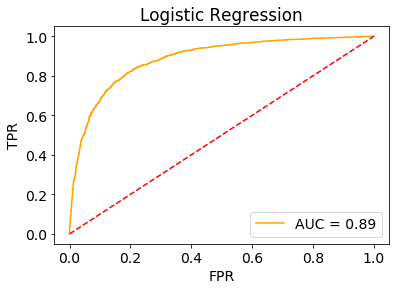

In [124]:
metrics(logit_clf, train_X_bow, test_X_bow, train_y_bow, test_y_bow,"Logistic Regression")

### 3.1.2 Logistic Regression with bag of words Gird search CV 

In [26]:
hyperparameters = dict(C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 
                       penalty = ['l2','l1',None],
                       solver = ['sag', 'saga','liblinear','newton-cg']
                      )

In [27]:
clf_log_gscv = GridSearchCV(logit_clf, hyperparameters, cv=5, verbose=True, n_jobs=-1)
clf_log = clf_log_gscv.fit(train_X_bow,train_y_bow)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 313 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 11.1min finished


In [30]:
clf_log.best_estimator_.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Training time: 0.480038s; Prediction time: 0.480038s
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2998
           1       0.82      0.82      0.82      2981

    accuracy                           0.82      5979
   macro avg       0.82      0.82      0.82      5979
weighted avg       0.82      0.82      0.82      5979

Confusion Matrix
[[2451  547]
 [ 529 2452]]


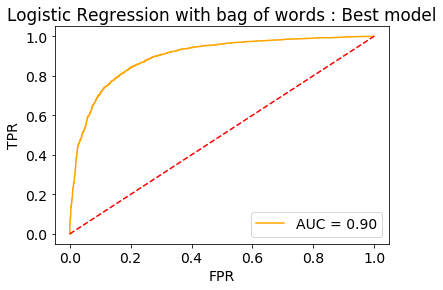

In [125]:
best_clf_log = LogisticRegression(C= 0.1, class_weight = None, dual= False,fit_intercept= True,
                                     intercept_scaling = 1, l1_ratio = None, max_iter = 100,
                                      multi_class = 'auto',penalty='l2', random_state = 0,
                                      solver = 'liblinear',tol =0.0001,verbose = 0,warm_start= False )
metrics(best_clf_log, train_X_bow, test_X_bow, train_y_bow, test_y_bow, "Logistic Regression with bag of words : Best model")


### 3.1.3 Logistic Regression with tf-idf

Training time: 0.201017s; Prediction time: 0.201017s
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2485
           1       0.85      0.85      0.85      2497

    accuracy                           0.85      4982
   macro avg       0.85      0.85      0.85      4982
weighted avg       0.85      0.85      0.85      4982

Confusion Matrix
[[2119  366]
 [ 380 2117]]


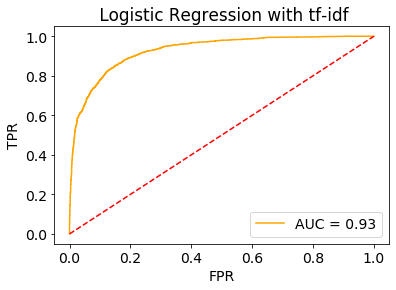

In [39]:
metrics(logit_clf, train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf , " Logistic Regression with tf-idf")

### 3.1.4 Logistic Regression withtf-idf Gird search CV 

In [18]:
hyperparameters = dict(C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 
                       penalty = ['l2','l1',None],
                       solver = ['sag', 'saga','liblinear','newton-cg']
                      )

In [19]:
clf_log_gscv_tfidf = GridSearchCV(logit_clf, hyperparameters, cv=5, verbose=True, n_jobs=-1)
clf_log_tfidf = clf_log_gscv_tfidf.fit(train_X_tfidf,train_y_tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.2min finished


In [34]:
clf_log_tfidf.best_estimator_.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Training time: 0.307023s; Prediction time: 0.307023s
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2485
           1       0.85      0.85      0.85      2497

    accuracy                           0.85      4982
   macro avg       0.85      0.85      0.85      4982
weighted avg       0.85      0.85      0.85      4982

Confusion Matrix
[[2119  366]
 [ 381 2116]]


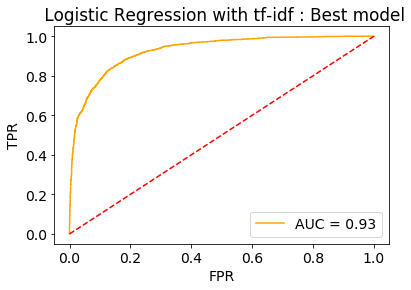

In [41]:
best_clf_log = LogisticRegression(C= 1, class_weight = None, dual= False,fit_intercept= True,
                                     intercept_scaling = 1, l1_ratio = None, max_iter = 100,
                                      multi_class = 'auto',penalty='l2', random_state = 0,
                                      solver = 'saga',tol =0.0001,verbose = 0,warm_start= False )
metrics(best_clf_log, train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf," Logistic Regression with tf-idf : Best model" )

### 3.1.5 Logistic Regression with bigram

Training time: 5.323397s; Prediction time: 5.323397s
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2998
           1       0.75      0.80      0.77      2981

    accuracy                           0.77      5979
   macro avg       0.77      0.77      0.77      5979
weighted avg       0.77      0.77      0.77      5979

Confusion Matrix
[[2184  814]
 [ 586 2395]]


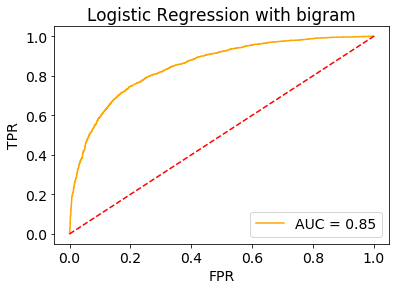

In [43]:
metrics(logit_clf, train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram , "Logistic Regression with bigram")

### 3.1.6 Logistic Regression with bigram  Gird search CV 

In [42]:
hyperparameters = dict(C = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], 
                       penalty = ['l2','l1',None],
                       solver = ['sag', 'saga','liblinear','newton-cg']
                      )

In [43]:
clf_log_gscv_bigram = GridSearchCV(logit_clf, hyperparameters, cv=5, verbose=True, n_jobs=-1)
clf_log_bigram = clf_log_gscv_bigram.fit(train_X_bigram,train_y_bigram)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 107.3min finished


In [46]:
clf_log_bigram.best_estimator_.get_params()

{'C': 10.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Training time: 7.894587s; Prediction time: 7.894587s
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      2998
           1       0.75      0.79      0.77      2981

    accuracy                           0.77      5979
   macro avg       0.77      0.77      0.77      5979
weighted avg       0.77      0.77      0.77      5979

Confusion Matrix
[[2234  764]
 [ 635 2346]]


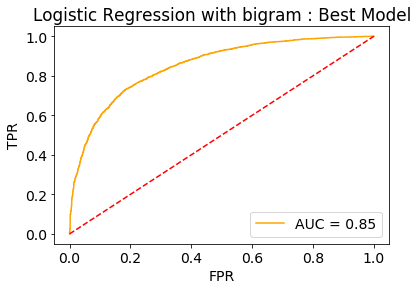

In [44]:
best_clf_log_bigram = LogisticRegression(C= 10, class_weight = None, dual= False,fit_intercept= True,
                                     intercept_scaling = 1, l1_ratio = None, max_iter = 100,
                                      multi_class = 'auto',penalty='l2', random_state = 0,
                                      solver = 'newton-cg',tol =0.0001,verbose = 0,warm_start= False )
metrics(best_clf_log_bigram, train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram,"Logistic Regression with bigram : Best Model")

## 3.2 SVM

In [126]:
svm_clf = svm.SVC(kernel='linear',probability = True)

### 3.2.1 SVM with bag of words

Training time: 312.501804s; Prediction time: 312.501804s
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2998
           1       0.78      0.79      0.78      2981

    accuracy                           0.78      5979
   macro avg       0.78      0.78      0.78      5979
weighted avg       0.78      0.78      0.78      5979

Confusion Matrix
[[2349  649]
 [ 639 2342]]


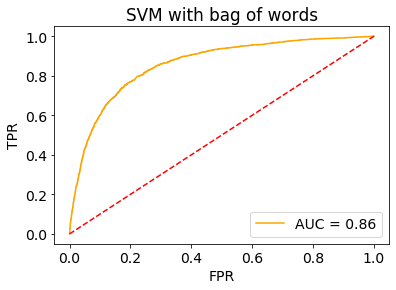

In [49]:
metrics(svm_clf, train_X_bow, test_X_bow, train_y_bow, test_y_bow,"SVM with bag of words" )

### 3.2.2 SVM with BOW GSCV 

In [23]:
svm_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [24]:
hyperparam_svm = {'C': [0.1,1, 10, 100], 
                  'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid','linear'],
                   'decision_function_shape': ['ovr','ovo']
                  }

In [25]:
clf_svm_bow_gscv = GridSearchCV(svm.SVC(), hyperparam_svm, cv=5, verbose=True, n_jobs=-1)
clf_svm_bow = clf_svm_bow_gscv.fit(train_X_bow,train_y_bow)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 106.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 158.8min finished


In [28]:
clf_svm_bow.best_params_

{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 0.001, 'kernel': 'rbf'}

Training time: 219.168597s; Prediction time: 219.168597s
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2998
           1       0.82      0.82      0.82      2981

    accuracy                           0.82      5979
   macro avg       0.82      0.82      0.82      5979
weighted avg       0.82      0.82      0.82      5979

Confusion Matrix
[[2451  547]
 [ 537 2444]]


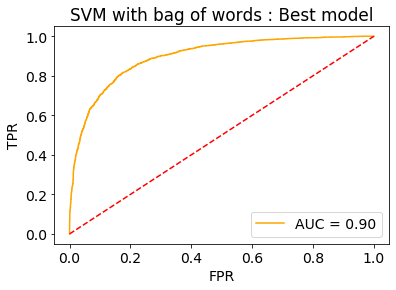

In [51]:
svm_clf_best = svm.SVC(C=10, gamma =  0.001, kernel = 'rbf', probability = True)
metrics(svm_clf_best, train_X_bow, test_X_bow, train_y_bow, test_y_bow ,"SVM with bag of words : Best model")

### 3.2.3 SVM with tfidf

Training time: 342.244439s; Prediction time: 342.244439s
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2485
           1       0.85      0.85      0.85      2497

    accuracy                           0.85      4982
   macro avg       0.85      0.85      0.85      4982
weighted avg       0.85      0.85      0.85      4982

Confusion Matrix
[[2102  383]
 [ 373 2124]]


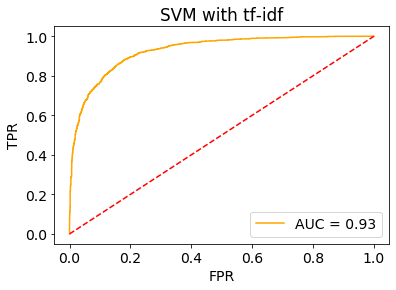

In [53]:
metrics(svm_clf, train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf, "SVM with tf-idf")


### 3.2.4 SVM with tfidf Grid search CV

In [23]:
hyperparam_svm = {'C': [0.1,1, 10, 100], 
                  'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid','linear'],
                   'decision_function_shape': ['ovr','ovo']
                  }

In [26]:
svm_clf = svm.SVC()
clf_svm_tfidf_gscv = GridSearchCV(svm_clf, hyperparam_svm, cv=5, verbose=True, n_jobs=-1)
clf_svm_tfidf = clf_svm_tfidf_gscv.fit(train_X_tfidf,train_y_tfidf)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 74.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 190.4min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 290.1min finished


In [28]:
clf_svm_tfidf.best_params_

{'C': 100, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'rbf'}

Training time: 1665.945618s; Prediction time: 1665.945618s
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2485
           1       0.86      0.86      0.86      2497

    accuracy                           0.86      4982
   macro avg       0.86      0.86      0.86      4982
weighted avg       0.86      0.86      0.86      4982

Confusion Matrix
[[2128  357]
 [ 355 2142]]


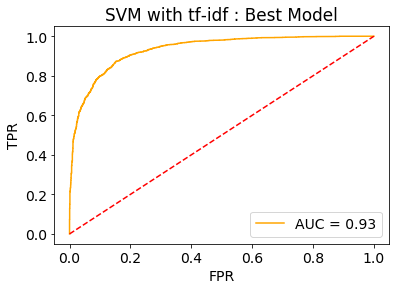

In [55]:
svm_clf_tfdif = svm.SVC(C=100, gamma =  1, kernel = 'rbf',probability = True)
metrics(svm_clf_tfdif, train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf, "SVM with tf-idf : Best Model")

### 3.2.5 SVM with bigram

Training time: 1659.003528s; Prediction time: 1659.003528s
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2998
           1       0.75      0.79      0.77      2981

    accuracy                           0.76      5979
   macro avg       0.76      0.76      0.76      5979
weighted avg       0.76      0.76      0.76      5979

Confusion Matrix
[[2206  792]
 [ 638 2343]]


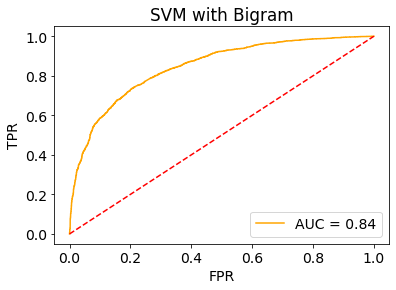

In [128]:
metrics(svm_clf, train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram,"SVM with Bigram")

### 3.2.6 SVM with bigram Grid Seach CV

In [24]:
hyperparam_svm = {'C': [0.1,1, 10, 100], 
                  'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid','linear'],
                   'decision_function_shape': ['ovr','ovo']
                 }

In [25]:
svm_clf = svm.SVC()
clf_svm_bigram_gscv = GridSearchCV(svm_clf, hyperparam_svm, cv=5, verbose=True, n_jobs=-1)
clf_svm_bigram = clf_svm_bigram_gscv.fit(train_X_bigram,train_y_bigram)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 90.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 231.4min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 368.1min finished


In [27]:
clf_svm_bigram.best_params_

{'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.001, 'kernel': 'rbf'}

Training time: 1109.119851s; Prediction time: 1109.119851s
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      2998
           1       0.75      0.77      0.76      2981

    accuracy                           0.76      5979
   macro avg       0.76      0.76      0.76      5979
weighted avg       0.76      0.76      0.76      5979

Confusion Matrix
[[2252  746]
 [ 698 2283]]


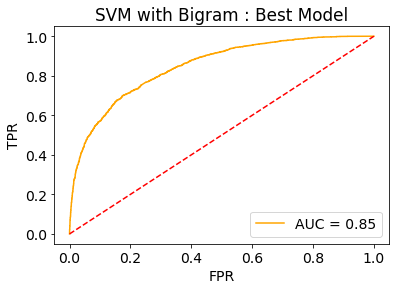

In [127]:
svm_clf_bigram= svm.SVC(C=100, gamma = 0.01, kernel = 'rbf' , probability = True)
metrics(svm_clf_bigram, train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram,"SVM with Bigram : Best Model")

## 3.3 Random Forest

In [130]:
rf_clf = RandomForestClassifier(random_state = 0)

### 3.3.1 Random Forest with bag of words

Training time: 73.571950s; Prediction time: 73.571950s
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2998
           1       0.83      0.76      0.79      2981

    accuracy                           0.80      5979
   macro avg       0.80      0.80      0.80      5979
weighted avg       0.80      0.80      0.80      5979

Confusion Matrix
[[2531  467]
 [ 726 2255]]


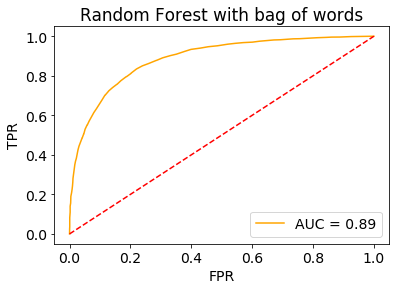

In [131]:
metrics(rf_clf, train_X_bow, test_X_bow, train_y_bow, test_y_bow, "Random Forest with bag of words")

### 3.3.2 Random Forest with bag of words GridSearch CV

In [26]:
# Final selected hyperparameters
param_grid = {'bootstrap': [False],
              'max_depth': [500],
              'min_samples_split': [10],
              'min_samples_leaf': [1],
              'n_estimators': [500],
              'criterion': ["entropy"],
              }

grid_random_forest_bow = GridSearchCV(estimator=rf_clf,param_grid=param_grid, cv = 3, verbose=2, n_jobs = -1)
grid_random_forest_bow.fit(train_X_bow, train_y_bow.values.ravel())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [27]:
print(grid_random_forest_bow.best_params_)
print('\n')
print('Accuracy of random forest classifier (bow) on test set after adjusting hyperparameters: {:.2f}'.format(grid_random_forest_bow.score(test_X_bow, test_y_bow)))

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 500, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


Accuracy of random forest classifier (bow) on test set after adjusting hyperparameters: 0.82


Training time: 404.035502s; Prediction time: 404.035502s
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3000
           1       0.83      0.80      0.81      2979

    accuracy                           0.82      5979
   macro avg       0.82      0.82      0.82      5979
weighted avg       0.82      0.82      0.82      5979

Confusion Matrix
[[2493  507]
 [ 583 2396]]


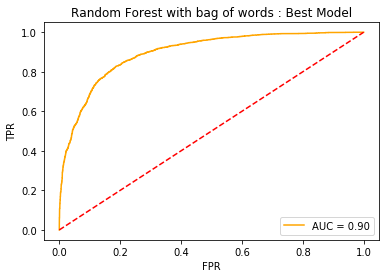

In [21]:
grid_random_forest_bow = RandomForestClassifier(random_state=0,bootstrap = False,
                       max_depth = 500,
                       min_samples_split = 10,
                       n_estimators = 500,
                       criterion = 'entropy')
metrics(grid_random_forest_bow, train_X_bow, test_X_bow, train_y_bow, test_y_bow, "Random Forest with bag of words : Best Model")

### 3.3.3 Random Forest with tfidf

Training time: 30.603870s; Prediction time: 30.603870s
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2485
           1       0.83      0.78      0.80      2497

    accuracy                           0.81      4982
   macro avg       0.81      0.81      0.81      4982
weighted avg       0.81      0.81      0.81      4982

Confusion Matrix
[[2072  413]
 [ 537 1960]]


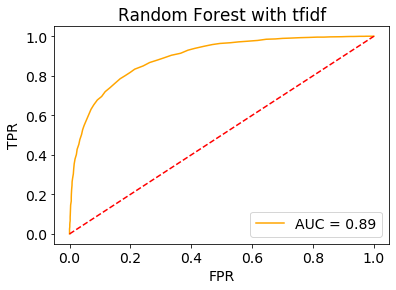

In [133]:
metrics(rf_clf, train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf, "Random Forest with tfidf")

### 3.3.4 Random Forest with tfidf gridsearch CV

In [33]:
# Selecting the best hyperparameters
param_grid = {'bootstrap': [False],
              'max_depth': [500],
              'min_samples_split': [10],
              'n_estimators': [1500],
              'criterion': ["entropy"]}

grid_random_forest_tfidf = GridSearchCV(estimator=rf_clf,param_grid=param_grid, cv=3, verbose=2, n_jobs = -1)
grid_random_forest_tfidf.fit(train_X_tfidf, train_y_tfidf.values.ravel())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [34]:
print(grid_random_forest_tfidf.best_params_)
print('\n')
print('Accuracy of random forest classifier (tfidf) on test set after adjusting hyperparameters: {:.2f}'.format(grid_random_forest_tfidf.score(test_X_tfidf, test_y_tfidf)))

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 500, 'min_samples_split': 10, 'n_estimators': 1500}


Accuracy of random forest classifier (tfidf) on test set after adjusting hyperparameters: 0.83


Training time: 220.246690s; Prediction time: 220.246690s
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2450
           1       0.85      0.82      0.83      2532

    accuracy                           0.83      4982
   macro avg       0.83      0.83      0.83      4982
weighted avg       0.83      0.83      0.83      4982

Confusion Matrix
[[2089  361]
 [ 465 2067]]


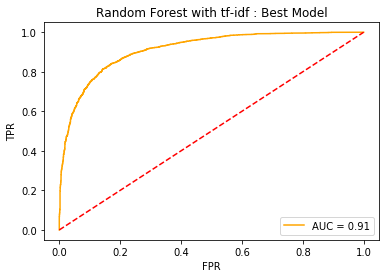

In [22]:
grid_random_forest_tfidf = RandomForestClassifier(random_state=0,bootstrap = False,
                       max_depth = 500,
                       min_samples_split = 10,
                       n_estimators = 500,
                       criterion = 'entropy')
metrics(grid_random_forest_tfidf, train_X_tfidf, test_X_tfidf, train_y_tfidf, test_y_tfidf, "Random Forest with tf-idf : Best Model")

### 3.3.5 Random Forest with bigram

Training time: 1343.783202s; Prediction time: 1343.783202s
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      2998
           1       0.79      0.64      0.71      2981

    accuracy                           0.73      5979
   macro avg       0.74      0.73      0.73      5979
weighted avg       0.74      0.73      0.73      5979

Confusion Matrix
[[2493  505]
 [1082 1899]]


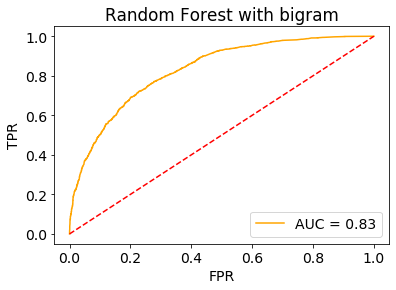

In [134]:
metrics(rf_clf, train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram,"Random Forest with bigram")

### 3.3.6 Random Forest with bigram gridsearch CV

In [136]:
param_grid = {'bootstrap': [False],
              'max_depth': [500],
              'min_samples_split': [10],
              'n_estimators': [500],
              'criterion': ["entropy"]}

grid_random_forest_bigram = RandomForestClassifier(random_state=0,
                                                   bootstrap = False,
                                                   max_depth = 500,
                                                   min_samples_split = 10,
                                                   n_estimators = 500,
                                                   criterion = 'entropy')


Training time: 4902.613534s; Prediction time: 4902.613534s
              precision    recall  f1-score   support

           0       0.76      0.71      0.74      3000
           1       0.73      0.78      0.75      2979

    accuracy                           0.74      5979
   macro avg       0.75      0.74      0.74      5979
weighted avg       0.75      0.74      0.74      5979

Confusion Matrix
[[2139  861]
 [ 668 2311]]


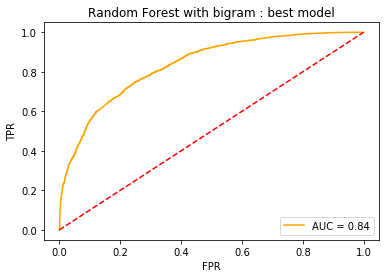

In [25]:
metrics(grid_random_forest_bigram, train_X_bigram, test_X_bigram, train_y_bigram, test_y_bigram, "Random Forest with bigram : best model")


# Best model

3.2.4 SVM with Tf-idf using hyperparameter tuning 